<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CRF相关函数" data-toc-modified-id="CRF相关函数-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CRF相关函数</a></span><ul class="toc-item"><li><span><a href="#维特比解码最优序列:" data-toc-modified-id="维特比解码最优序列:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>维特比解码最优序列:</a></span></li><li><span><a href="#计算真实序列的分数" data-toc-modified-id="计算真实序列的分数-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>计算真实序列的分数</a></span></li><li><span><a href="#计算所有可能路径的分数" data-toc-modified-id="计算所有可能路径的分数-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>计算所有可能路径的分数</a></span></li><li><span><a href="#计算损失函数：真实序列分数---所有可能路径分数" data-toc-modified-id="计算损失函数：真实序列分数---所有可能路径分数-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>计算损失函数：真实序列分数 - 所有可能路径分数</a></span></li></ul></li><li><span><a href="#数据" data-toc-modified-id="数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据</a></span><ul class="toc-item"><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>数据预处理</a></span></li><li><span><a href="#数据管道" data-toc-modified-id="数据管道-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>数据管道</a></span></li></ul></li><li><span><a href="#BiLSTM-CRF模型" data-toc-modified-id="BiLSTM-CRF模型-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BiLSTM-CRF模型</a></span><ul class="toc-item"><li><span><a href="#CRF-层" data-toc-modified-id="CRF-层-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CRF 层</a></span></li><li><span><a href="#BiLSTM-CRF" data-toc-modified-id="BiLSTM-CRF-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>BiLSTM-CRF</a></span></li></ul></li><li><span><a href="#训练模型" data-toc-modified-id="训练模型-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>训练模型</a></span></li></ul></div>

In [4]:
import tensorflow as tf
import numpy as np

# CRF相关函数
https://github.com/tensorflow/addons/blob/master/tensorflow_addons/text/crf.py

>***需要注意的是***：
* 如果标签中是添加了 `<start>` 和 `<end>` 标签的：
* 转移矩阵维度应该是 真实标签数量+2
* 且初始序列输入模型前要：在序列首部添加了`<start>`，尾部添加了`<end>`

## 维特比解码最优序列:

In [5]:
# 解码过程，获取最佳预测标签序列；只在测试阶段使用
def viterbi_decode(score, transition_params):
    """Decode the highest scoring sequence of tags outside of TensorFlow.
    This should only be used at test time.
    Args:
      score: A [seq_len, num_tags] matrix of unary potentials.
      transition_params: A [num_tags, num_tags] matrix of binary potentials.
    Returns:
      viterbi: A [seq_len] list of integers containing the highest scoring tag
          indices.
      viterbi_score: A float containing the score for the Viterbi sequence.
    """
    trellis = np.zeros_like(score)
    backpointers = np.zeros_like(score, dtype=np.int32)
    
    trellis[0] = score[0]

    for t in range(1, score.shape[0]):
        v = np.expand_dims(trellis[t - 1], 1) + transition_params
        trellis[t] = score[t] + np.max(v, 0)
        backpointers[t] = np.argmax(v, 0)

    viterbi = [np.argmax(trellis[-1])]
    for bp in reversed(backpointers[1:]):
        viterbi.append(bp[viterbi[-1]])
    viterbi.reverse()

    viterbi_score = np.max(trellis[-1])
    return viterbi, viterbi_score

# 如果标签中是添加了 <start> 和 <end> 标签的：
# 转移矩阵维度应该是 真实标签数量+2
# 且初始序列输入模型前要：在序列首部添加了<start>，尾部添加了<end>

In [6]:
score = tf.random.normal([3, 5], -3, 3, tf.float32)
tf.print(score)
transition_params = tf.random.normal([5, 5], 0, 1, tf.float32)

viterbi_decode(score, transition_params)

[[-0.0927515 -6.01208925 -3.81539488 -1.89488077 1.32547951]
 [-5.96362209 1.49758339 -7.21282959 -2.30758834 -1.50181127]
 [-1.82406688 0.679782867 -6.83573961 -2.94501209 -5.43150282]]


([4, 1, 1], 3.6936946)

## 计算真实序列的分数

**第一部分：标签本身的发射分数**

<img src="../images/seq_emission.png" width="40%" align="">
  
- 如上图所示，批序列的发射矩阵`Emission Matrix: (batch_size,seq_len,num_tags)`，表示序列每个元素对应的标签分布
- **红色部分对应序列每个元素的真实标签** 的索引，需要提取出该处的发射分数；首先获取所有索引：

```python
>>> offsets = tf.expand_dims(tf.range(batch_size) * max_seq_len * num_tags, 1)
>>> offsets += tf.expand_dims(tf.range(max_seq_len) * num_tags, 0)
>>> flattened_tag_indices = tf.reshape(offsets + tag_indices, [-1])
<tf.Tensor: shape=(10,),numpy=array([ 1,  5, 14, 16, 22, 27, 34, 36, 41, 47])>
```

In [7]:
def crf_unary_score(tag_indices, sequence_lengths, inputs):
    """Computes the unary scores of tag sequences.
    Args:
      tag_indices: A [batch_size, max_seq_len] matrix of tag indices.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
      inputs: A [batch_size, max_seq_len, num_tags] tensor of unary potentials.
    Returns:
      unary_scores: A [batch_size] vector of unary scores.
    """
    tag_indices = tf.cast(tag_indices, dtype=tf.int32)
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

    batch_size = tf.shape(inputs)[0]
    max_seq_len = tf.shape(inputs)[1]
    num_tags = tf.shape(inputs)[2]

    flattened_inputs = tf.reshape(inputs,
                                  [-1])  # batch_size * max_seq_len * num_tags

    # inputs 输入批数据的 预测 标签分布 [batch_size, max_seq_len, num_tags] 展平之后，
    # 用来标记每个元素的标签分布的起点索引
    offsets = tf.expand_dims(tf.range(batch_size) * max_seq_len * num_tags, 1)
    offsets += tf.expand_dims(tf.range(max_seq_len) * num_tags, 0)

    # Use int32 or int64 based on tag_indices' dtype.
    if tag_indices.dtype == tf.int64:
        offsets = tf.cast(offsets, tf.int64)

    # 批数据对应的每个元素的真实标签 tag_indices 对应的索引
    flattened_tag_indices = tf.reshape(offsets + tag_indices, [-1])

    # 搜集真实标签对应的所有发射分数
    unary_scores = tf.reshape(
        tf.gather(flattened_inputs, flattened_tag_indices),
        [batch_size, max_seq_len])

    masks = tf.sequence_mask(sequence_lengths,
                             maxlen=tf.shape(tag_indices)[1],
                             dtype=tf.float32)

    unary_scores = tf.reduce_sum(unary_scores * masks, 1)
    return unary_scores

In [8]:
tag_indices = tf.constant(np.random.randint(0, 5, size=(2, 5), dtype=np.int32))
sequence_lengths = tf.constant([4, 3])
inputs = tf.random.normal([2, 5, 5], 0, 1, dtype=tf.float32)
crf_unary_score(tag_indices, sequence_lengths, inputs)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.01192498,  1.4510444 ], dtype=float32)>

**第二部分：相邻标签间的转移分数**
   
<img src="../images/seq_transition.png" width="30%">
  
- 如上图中，与输入数据无关的转移矩阵，表征标签之间的关系，每一行表示 **当前标签指向其他标签** 的转移分数
- 标签序列，`<start> -> tag3 -> tag2 -> tag1 -> <end>`，对应的转移分数如图中 **红色部分** 所示；
    - 需要间批量标签序列对应的转移分数提取出来，首先获取所有索引

```python
>>> tag_indices = tf.constant([[0, 3, 2, 1, 4]])
>>> start_tag_indices = tf.slice(tag_indices, [0, 0],[-1, 4])  
<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 3, 2, 1]], dtype=int32)>
    
>>> end_tag_indices = tf.slice(tag_indices, [0, 1],[-1, 4])
<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[3, 2, 1, 4]], dtype=int32)>
    
>>> flattened_transition_indices = start_tag_indices * num_tags + end_tag_indices
<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[ 3, 17, 11,  9]], dtype=int32)>
```    

In [9]:
def crf_binary_score(tag_indices, sequence_lengths, transition_params):
    """Computes the binary scores of tag sequences.
    Args:
      tag_indices: A [batch_size, max_seq_len] matrix of tag indices.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
      transition_params: A [num_tags, num_tags] matrix of binary potentials.
    Returns:
      binary_scores: A [batch_size] vector of binary scores.
    """
    tag_indices = tf.cast(tag_indices, dtype=tf.int32)
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

    num_tags = tf.shape(transition_params)[0]
    num_transitions = tf.shape(tag_indices)[1] - 1  # 10 个标签只有 9 个转移分数

    # tag_indices[:,:-1]，表示 行索引
    start_tag_indices = tf.slice(tag_indices, [0, 0], [-1, num_transitions])

    # tag_indices[:,1:]，表示 列索引
    end_tag_indices = tf.slice(tag_indices, [0, 1], [-1, num_transitions])

    # 展平后的索引
    flattened_transition_indices = start_tag_indices * num_tags + end_tag_indices
    flattened_transition_params = tf.reshape(transition_params, [-1])

    # 根据索引获得转移分数
    binary_scores = tf.gather(flattened_transition_params,
                              flattened_transition_indices)

    masks = tf.sequence_mask(sequence_lengths,
                             maxlen=tf.shape(tag_indices)[1],
                             dtype=tf.float32)
    truncated_masks = tf.slice(masks, [0, 1], [-1, -1])
    binary_scores = tf.reduce_sum(binary_scores * truncated_masks, 1)
    return binary_scores

In [10]:
tag_indices = tf.constant([[0, 3, 2, 1, 4]])
sequence_lengths = tf.constant([4])
transition_params = tf.random.normal([5, 5], 0, 1, dtype=tf.float32)
crf_binary_score(tag_indices, sequence_lengths, transition_params)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.45172417], dtype=float32)>

**发射分数+转移分数**

In [11]:
def crf_sequence_score(
        inputs,
        tag_indices,
        sequence_lengths,
        transition_params,
):
    """Computes the unnormalized score for a tag sequence.
    Args:
      inputs: A [batch_size, max_seq_len, num_tags] tensor of unary potentials
          to use as input to the CRF layer.
      tag_indices: A [batch_size, max_seq_len] matrix of tag indices for which
          we compute the unnormalized score.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
      transition_params: A [num_tags, num_tags] transition matrix.
    Returns:
      sequence_scores: A [batch_size] vector of unnormalized sequence scores.
    """
    tag_indices = tf.cast(tag_indices, dtype=tf.int32)
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

    # If max_seq_len is 1, we skip the score calculation and simply gather the
    # unary potentials of the single tag.
    def _single_seq_fn():
        batch_size = tf.shape(inputs, out_type=tf.int32)[0]
        batch_inds = tf.reshape(tf.range(batch_size), [-1, 1])
        indices = tf.concat([batch_inds, tf.zeros_like(batch_inds)], axis=1)

        tag_inds = tf.gather_nd(tag_indices, indices)
        tag_inds = tf.reshape(tag_inds, [-1, 1])
        indices = tf.concat([indices, tag_inds], axis=1)

        sequence_scores = tf.gather_nd(inputs, indices)

        sequence_scores = tf.where(
            tf.less_equal(sequence_lengths, 0),
            tf.zeros_like(sequence_scores),
            sequence_scores,
        )
        return sequence_scores

    def _multi_seq_fn():
        # Compute the scores of the given tag sequence.
        unary_scores = crf_unary_score(tag_indices, sequence_lengths, inputs)
        binary_scores = crf_binary_score(tag_indices, sequence_lengths,
                                         transition_params)
        sequence_scores = unary_scores + binary_scores
        return sequence_scores

    return tf.cond(tf.equal(tf.shape(inputs)[1], 1), _single_seq_fn,
                   _multi_seq_fn)

In [12]:
inputs = tf.random.normal([2, 5, 5], 0, 1, dtype=tf.float32)
tag_indices = tf.constant([[0, 3, 2, 1, 4], [1, 2, 3, 4, 2]])
sequence_lengths = tf.constant([4, 5])
transition_params = tf.random.normal([5, 5], 0, 1, dtype=tf.float32)
crf_sequence_score(inputs, tag_indices, sequence_lengths, transition_params)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.972989 ,  1.9951336], dtype=float32)>

## 计算所有可能路径的分数
<img src="../images/crf_forward2.png" width="100%">

- 如上图所示：`all_alpha` 记录序列到当前标签时的所有路径的分数，其形状与 发射矩阵(`Emsission Matrix`)的相同
    - `(i,j,k)`表示，数据批次 j 中，长为 i 的序列，以标签 k 结尾的所有路径的分数
- 序列位置1、数据批位置0 处的状态 `_state`，与 `transmition_scores[:,0]` 按位求和，然后 `log_sum_exp`操作，再加上位置 0 处的发射分数，可得到 （2，1，1）处的所有路径的分数。具体的实现如下所示:

```python

>>> state = tf.constant([[0.3, 0.5, 0.2], [0.8, 0.1, 0.1]])
>>> _state = tf.expand_dims(_state, 2)
<tf.Tensor: shape=(2, 3, 1), dtype=float32, numpy=
array([[[0.3],
        [0.5],
        [0.2]],

       [[0.8],
        [0.1],
        [0.1]]], dtype=float32)>

>>> transition_params = tf.expand_dims(transition_params, 0)
<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 0.33 ,  0.81 , -0.96 ],
        [ 0.85 , -0.37 , -0.37 ],
        [ 0.74 ,  0.67 ,  0.36]]], dtype=float32)>

>>> transition_scores = _state + transition_params
>>> new_alphas = _inputs + tf.reduce_logsumexp(transition_scores, [1])

```

- 上述为状态更新，整个批序列的计算利用 `tf.scan(_scan_fn, inputs, state)` 函数扫描 批数据 来实现


**动态规划依次计算序列每个元素选择不同标签时的分数分布**

In [13]:
def crf_forward(inputs, state, transition_params, sequence_lengths):
    """Computes the alpha values in a linear-chain CRF.
    See http://www.cs.columbia.edu/~mcollins/fb.pdf for reference.
    Args:
      inputs: A [batch_size, seq_len, num_tags] matrix of unary potentials.
      state: A [batch_size, num_tags] matrix containing the previous alpha
         values.
      transition_params: A [num_tags, num_tags] matrix of binary potentials.
          This matrix is expanded into a [1, num_tags, num_tags] in preparation
          for the broadcast summation occurring within the cell.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
    Returns:
      new_alphas: A [batch_size, num_tags] matrix containing the
          new alpha values.
    """
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

    last_index = tf.maximum(tf.constant(0, dtype=sequence_lengths.dtype),
                            sequence_lengths - 1)

    # (seq, batch, num_tags)
    inputs = tf.transpose(inputs, [1, 0, 2])

    # (0, num_tags, num_tags)
    transition_params = tf.expand_dims(transition_params, 0)

    # 跟定前一状态 _state 和当前的输入 _inputs 计算下一状态
    def _scan_fn(_state, _inputs):
        _state = tf.expand_dims(_state, 2)
        transition_scores = _state + transition_params
        new_alphas = _inputs + tf.reduce_logsumexp(transition_scores, [1])
        return new_alphas

    # batch, seq_len,num_tags
    all_alphas = tf.transpose(tf.scan(_scan_fn, inputs, state), [1, 0, 2])
    # add first state for sequences of length 1
    all_alphas = tf.concat([tf.expand_dims(state, 1), all_alphas], 1)

    print(all_alphas)
    idxs = tf.stack([tf.range(tf.shape(last_index)[0]), last_index], axis=1)

    # 提取序列最后一个元素对应的标签分布
    return tf.gather_nd(all_alphas, idxs)



In [14]:
inputs = tf.cast(tf.constant(np.random.randn(2, 4, 3)), dtype=tf.float32)
state = tf.constant([[0.3, 0.5, 0.2], [0.3, 0.5, 0.2]])
transition_params = tf.random.normal([3, 3], 0, 1, dtype=tf.float32)
sequence_lengths = tf.constant([3, 4])
crf_forward(inputs, state, transition_params, sequence_lengths)

tf.Tensor(
[[[0.3        0.5        0.2       ]
  [0.02976155 2.7336693  1.878243  ]
  [4.8469076  5.0028214  4.556198  ]
  [4.85318    6.11074    5.758291  ]
  [6.537819   7.1076956  6.1912208 ]]

 [[0.3        0.5        0.2       ]
  [0.6584582  1.780944   0.88176346]
  [0.76113594 2.8900719  0.10402226]
  [3.973981   4.6565375  3.080339  ]
  [5.333847   6.0549397  3.6676145 ]]], shape=(2, 5, 3), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[4.8469076, 5.0028214, 4.556198 ],
       [3.973981 , 4.6565375, 3.080339 ]], dtype=float32)>

**计算所有路径的分数**

In [15]:
def crf_log_norm(inputs, sequence_lengths, transition_params):
    """Computes the normalization for a CRF.
    Args:
      inputs: A [batch_size, max_seq_len, num_tags] tensor of unary potentials
          to use as input to the CRF layer.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
      transition_params: A [num_tags, num_tags] transition matrix.
    Returns:
      log_norm: A [batch_size] vector of normalizers for a CRF.
    """
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)
    # Split up the first and rest of the inputs in preparation for the forward
    # algorithm.
    first_input = tf.slice(inputs, [0, 0, 0], [-1, 1, -1])
    first_input = tf.squeeze(first_input, [1])

    # If max_seq_len is 1, we skip the algorithm and simply reduce_logsumexp
    # over the "initial state" (the unary potentials).
    def _single_seq_fn():
        log_norm = tf.reduce_logsumexp(first_input, [1])
        # Mask `log_norm` of the sequences with length <= zero.
        log_norm = tf.where(tf.less_equal(sequence_lengths, 0),
                            tf.zeros_like(log_norm), log_norm)
        return log_norm

    def _multi_seq_fn():
        """Forward computation of alpha values."""
        rest_of_input = tf.slice(inputs, [0, 1, 0], [-1, -1, -1])
        # Compute the alpha values in the forward algorithm in order to get the
        # partition function.

        alphas = crf_forward(rest_of_input, first_input, transition_params,
                             sequence_lengths)
        # logsum_exp 求得最终的分数，（batch,)
        log_norm = tf.reduce_logsumexp(alphas, [1])
        # Mask `log_norm` of the sequences with length <= zero.
        log_norm = tf.where(tf.less_equal(sequence_lengths, 0),
                            tf.zeros_like(log_norm), log_norm)
        return log_norm

    return tf.cond(tf.equal(tf.shape(inputs)[1], 1), _single_seq_fn,
                   _multi_seq_fn)


# 如果标签中是添加了 <start> 和 <end> 标签的：
# 转移矩阵维度应该是 真实标签数量+2
# 且初始序列输入模型前要：在序列首部添加了<start>，尾部添加了<end>

## 计算损失函数：真实序列分数 - 所有可能路径分数

In [16]:
def crf_log_likelihood(
        inputs,
        tag_indices,
        sequence_lengths,
        transition_params,
):
    """Computes the log-likelihood of tag sequences in a CRF.
    Args:
      inputs: A [batch_size, max_seq_len, num_tags] tensor of unary potentials
          to use as input to the CRF layer.
      tag_indices: A [batch_size, max_seq_len] matrix of tag indices for which
          we compute the log-likelihood.
      sequence_lengths: A [batch_size] vector of true sequence lengths.
      transition_params: A [num_tags, num_tags] transition matrix,
          if available.
    Returns:
      log_likelihood: A [batch_size] `Tensor` containing the log-likelihood of
        each example, given the sequence of tag indices.
      transition_params: A [num_tags, num_tags] transition matrix. This is
          either provided by the caller or created in this function.
    """
    num_tags = inputs.shape[2]

    # cast type to handle different types
    tag_indices = tf.cast(tag_indices, dtype=tf.int32)
    sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

    if transition_params is None:
        initializer = tf.keras.initializers.GlorotUniform()
        transition_params = tf.Variable(initializer([num_tags, num_tags]),
                                        "transitions")

    sequence_scores = crf_sequence_score(inputs, tag_indices, sequence_lengths,
                                         transition_params)
    log_norm = crf_log_norm(inputs, sequence_lengths, transition_params)

    # Normalize the scores to get the log-likelihood per example.
    log_likelihood = sequence_scores - log_norm
    return log_likelihood, transition_params

In [17]:
inputs = tf.cast(tf.constant(np.random.randn(2, 5, 5)), dtype=tf.float32)
tag_indices = tf.constant([[0, 3, 2, 1, 4], [1, 2, 3, 4, 2]])
sequence_lengths = tf.constant([4, 5])
transition_params = tf.random.normal([5, 5], 0, 1, dtype=tf.float32)

crf_log_likelihood(inputs, tag_indices, sequence_lengths, transition_params)

tf.Tensor(
[[[ 0.67091817  1.3500911  -0.05830282 -0.55953085  0.96454406]
  [ 0.9391037   1.8904927   3.880562    0.6520457   3.2143364 ]
  [ 4.7860045   3.7422829   5.580221    3.3637254   6.6998377 ]
  [ 7.682144    7.129279    9.459488    9.789771    7.2067914 ]
  [12.109924    9.423332    8.724604   11.826677   11.594567  ]]

 [[ 1.3308488   1.0649064   0.35129532  1.2887689   0.9186205 ]
  [ 2.587325    2.6766222   3.085214    3.4704711   1.3921077 ]
  [ 4.096512    4.5041537   4.273087    5.0115013   3.7085311 ]
  [ 7.044131    7.0319843   6.3996954   6.170608    5.2368846 ]
  [ 8.303185    8.757935    8.244911    7.3645124  10.207128  ]]], shape=(2, 5, 5), dtype=float32)


(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-11.006062, -10.432172], dtype=float32)>,
 <tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[ 0.88722306, -0.32255268, -0.28513208,  1.0004143 , -0.27743426],
        [-0.37235793,  0.6622775 ,  1.8824829 , -1.51814   , -0.57653904],
        [-0.34418008, -0.8495117 ,  0.9781507 ,  0.14777964,  2.644441  ],
        [ 1.2366235 , -0.60001117, -0.70971197,  0.6309414 , -0.01937208],
        [ 0.6109317 , -1.0831752 ,  0.24548076, -0.35030913, -1.1763878 ]],
       dtype=float32)>)

# 数据
数据需要处理成 输入序列+标签序列+序列长度 的形式   
```
inputs:
    [[6, 3, 2, 4, 0], 
     [5, 9, 3, 6, 2]]
targets:
    [[0, 3, 2, 1, 4], 
     [1, 2, 3, 4, 2]]
seq_lens:
    [4, 5]
```

## 数据预处理

In [18]:
# https://github.com/buppt/ChineseNER/blob/master/data/renMinRiBao/data_renmin_word.py
import os
import codecs
import re
import pdb
import pandas as pd
import numpy as np
import collections
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences


def data2pkl():
    datas = list()
    labels = list()
    seq_lens = list()

    all_words = []
    tags = set()

    input_data = codecs.open('../datasets/ner/renmin/renmin4.txt', 'r',
                             'utf-8')

    # 1. 将标注子句 拆分成 字列表 和 对应的标注列表 #############
    #####################################################
    for line in input_data.readlines():
        linedata = list()
        linelabel = list()

        line = line.split()

        numNotO = 0
        for word in line:
            word = word.split('/')
            linedata.append(word[0])
            linelabel.append(word[1])

            all_words.append(word[0])
            tags.add(word[1])

            if word[1] != 'O':  # 标注全为 O 的子句
                numNotO += 1

        if numNotO != 0:  # 只保存 标注不全为 O 的子句
            #             print(linedata)
            datas.append(linedata)
            labels.append(linelabel)
            seq_lens.append(len(linedata))

    input_data.close()
    print("文本序列的数量：", len(datas))  # 字列表 组成的列表
    assert (len(labels) == len(datas))  # 对应的 标注列表 组成的列表
    print("文本所有单词数：", len(all_words))

    # 2. 创建词汇表和标签表 ################################
    #####################################################

    words_count = collections.Counter(all_words).most_common()
    word2id = {word: i for i, (word, _) in enumerate(words_count, 1)}
    word2id["unknow"] = len(word2id) + 1

    id2word = {i: word for word, i in word2id.items()}
    print("词汇表的大小：", len(id2word))

    print("所有标签：", tags)
    tag2id = {tag: i for i, tag in enumerate(tags)}
    print(tag2id)

    id2tag = {i: tag for tag, i in tag2id.items()}
    print(id2tag)

    print("-" * 100)
    print("Buiding vocab Done!!!")

    # 3. 数据向量化，并处理成相同长度 ########################
    #####################################################
    max_len = 60

    data_ids = [[word2id[w] for w in line] for line in datas]
    label_ids = [[tag2id[t] for t in line] for line in labels]

    x = pad_sequences(data_ids, maxlen=max_len, padding='post')
    y = pad_sequences(label_ids, maxlen=max_len, padding='post')
    seq_lens = np.array(seq_lens)

    print("-" * 100)
    print("Vectorizing data Done!!!")

    # 4. 向量化后数据拆分成训练集、验证集、测试集 ##############
    #####################################################
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test, train_lens, test_lens = train_test_split(
        x,
        y,
        seq_lens,
        test_size=0.2,
        random_state=43,
    )
    x_train, x_valid, y_train, y_valid, train_lens, valid_lens = train_test_split(
        x_train,
        y_train,
        train_lens,
        test_size=0.2,
        random_state=43,
    )

    print("-" * 100)
    print("Splitting data Done!!!")

    # 5. 保存数据 ########################
    #####################################################

    import pickle
    import os
    with open('../datasets/ner/renmin/renmindata_TF.pkl', 'wb') as outp:
        pickle.dump(word2id, outp)
        pickle.dump(id2word, outp)
        pickle.dump(tag2id, outp)
        pickle.dump(id2tag, outp)

        pickle.dump(x_train, outp)
        pickle.dump(y_train, outp)
        pickle.dump(train_lens, outp)

        pickle.dump(x_test, outp)
        pickle.dump(y_test, outp)
        pickle.dump(test_lens, outp)

        pickle.dump(x_valid, outp)
        pickle.dump(y_valid, outp)
        pickle.dump(valid_lens, outp)

    print("-" * 100)
    print('** Finished saving the data.')
    return lens


# lens = data2pkl()

In [19]:
# 加载数据

import pickle

pickle_path = '../datasets/ner/renmin/renmindata_TF.pkl'
with open(pickle_path, 'rb') as inp:
    word2id = pickle.load(inp)
    id2word = pickle.load(inp)
    tag2id = pickle.load(inp)
    id2tag = pickle.load(inp)
    
    x_train = pickle.load(inp)
    y_train = pickle.load(inp)
    train_lens = pickle.load(inp)
    
    x_test = pickle.load(inp)
    y_test = pickle.load(inp)
    test_lens = pickle.load(inp)

    x_valid = pickle.load(inp)
    y_valid = pickle.load(inp)
    valid_lens = pickle.load(inp)
    
print("train len:", len(x_train))
print("test len:", len(x_test))
print("valid len:", len(x_valid))

train len: 24271
test len: 7585
valid len: 6068


In [20]:
x_train.shape, y_train.shape, train_lens.shape

((24271, 60), (24271, 60), (24271,))

In [21]:
import random


def test_data(i):
    k = 0
    for word_id, label_id in zip(x_train[i], y_train[i]):
        if k < train_lens[i]:
            print(f"word:{id2word[word_id]} --> label:{id2tag[label_id]}")
            k += 1


test_data(random.randint(0, 24271))

word:这 --> label:O
word:种 --> label:O
word:信 --> label:O
word:念 --> label:O
word:深 --> label:O
word:深 --> label:O
word:地 --> label:O
word:刻 --> label:O
word:在 --> label:O
word:了 --> label:O
word:小 --> label:O
word:王 --> label:B_nr
word:磊 --> label:E_nr
word:和 --> label:O
word:他 --> label:O
word:的 --> label:O
word:同 --> label:O
word:学 --> label:O
word:们 --> label:O
word:心 --> label:O
word:中 --> label:O


## 数据管道

In [22]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train, train_lens))
train_dataset = train_dataset.batch(batch_size).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (x_valid, y_valid, valid_lens))
valid_dataset = valid_dataset.batch(batch_size).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, test_lens))
test_dataset = test_dataset.batch(batch_size).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

# BiLSTM-CRF模型

## CRF 层

In [23]:
# from tensorflow.python.framework import dtypes


# # 用来初始化转移矩阵
# class TransitionInit:
#     def __call__(self, shape, dtype=dtypes.float32):
#         """Returns a tensor object initialized as specified by the initializer.
#     Args:
#       shape: Shape of the tensor.
#       dtype: Optional dtype of the tensor. Only numeric or boolean dtypes are
#        supported.
#     Raises:
#       ValuesError: If the dtype is not numeric or boolean.
#     """
#         dtype = dtypes.as_dtype(dtype)
#         if not dtype.is_numpy_compatible or dtype == dtypes.string:
#             raise ValueError("Expected numeric or boolean dtype, got %s." %
#                              dtype)

#         transitions = np.random.uniform(-0.1, 0.1, shape)

#         # 任意标签 --> <start> 标签的转移分数
#         transitions[:, 0] = -1000.0

#         # <end> --> 任意标签的 转移分数
#         transitions[-1, :] = -1000.0
#         return tf.cast(transitions, dtype=dtype)

In [24]:
# class CRF(tf.keras.layers.Layer):
#     def __init__(self, num_tags):
#         super(CRF, self).__init__()
#         self.num_tags = num_tags

#     def build(self, input_shape):
#         self.transitions = self.add_weight(
#             name="transition_matrix",
#             shape=[self.num_tags, self.num_tags],
#             initializer=tf.keras.initializers.glorot_uniform())

#     def call(self, inputs, tag_indices, sequence_lengths):
#         sequence_scores = self.crf_sequence_score(
#             inputs,
#             tag_indices,
#             sequence_lengths,
#             self.transitions,
#         )
#         log_norm = self.crf_log_norm(
#             inputs,
#             sequence_lengths,
#             self.transitions,
#         )
#         return sequence_scores - log_norm

#     def crf_sequence_score(
#             self,
#             inputs,
#             tag_indices,
#             sequence_lengths,
#             transition_params,
#     ):
#         unary_scores = self.crf_unary_score(tag_indices, sequence_lengths,
#                                             inputs)
#         binary_scores = self.crf_binary_score(tag_indices, sequence_lengths,
#                                               transition_params)
#         sequence_scores = unary_scores + binary_scores
#         return sequence_scores

#     def crf_unary_score(self, tag_indices, sequence_lengths, inputs):
#         tag_indices = tf.cast(tag_indices, dtype=tf.int32)
#         sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

#         batch_size = tf.shape(inputs)[0]
#         max_seq_len = tf.shape(inputs)[1]
#         num_tags = tf.shape(inputs)[2]

#         # batch_size * max_seq_len * num_tags
#         flattened_inputs = tf.reshape(inputs, [-1])

#         # inputs 输入批数据的 预测 标签分布 [batch_size, max_seq_len, num_tags] 展平之后，
#         # 用来标记每个元素的标签分布的起点索引
#         offsets = tf.expand_dims(
#             tf.range(batch_size) * max_seq_len * num_tags, 1)
#         offsets += tf.expand_dims(tf.range(max_seq_len) * num_tags, 0)

#         # Use int32 or int64 based on tag_indices' dtype.
#         if tag_indices.dtype == tf.int64:
#             offsets = tf.cast(offsets, tf.int64)

#         # 批数据对应的每个元素的真实标签 tag_indices 对应的索引
#         flattened_tag_indices = tf.reshape(offsets + tag_indices, [-1])

#         # 搜集真实标签对应的所有发射分数
#         unary_scores = tf.reshape(
#             tf.gather(flattened_inputs, flattened_tag_indices),
#             [batch_size, max_seq_len])

#         masks = tf.sequence_mask(sequence_lengths,
#                                  maxlen=tf.shape(tag_indices)[1],
#                                  dtype=tf.float32)

#         unary_scores = tf.reduce_sum(unary_scores * masks, 1)
#         return unary_scores

#     def crf_binary_score(self, tag_indices, sequence_lengths,
#                          transition_params):
#         tag_indices = tf.cast(tag_indices, dtype=tf.int32)
#         sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

#         num_tags = tf.shape(transition_params)[0]
#         num_transitions = tf.shape(tag_indices)[1] - 1  # 10 个标签只有 9 个转移分数

#         # tag_indices[:,:-1]，表示 行索引
#         start_tag_indices = tf.slice(tag_indices, [0, 0],
#                                      [-1, num_transitions])

#         # tag_indices[:,1:]，表示 列索引
#         end_tag_indices = tf.slice(tag_indices, [0, 1], [-1, num_transitions])

#         # 展平后的索引
#         flattened_transition_indices = start_tag_indices * num_tags + end_tag_indices
#         flattened_transition_params = tf.reshape(transition_params, [-1])

#         # 根据索引获得转移分数
#         binary_scores = tf.gather(flattened_transition_params,
#                                   flattened_transition_indices)

#         masks = tf.sequence_mask(sequence_lengths,
#                                  maxlen=tf.shape(tag_indices)[1],
#                                  dtype=tf.float32)
#         truncated_masks = tf.slice(masks, [0, 1], [-1, -1])
#         binary_scores = tf.reduce_sum(binary_scores * truncated_masks, 1)
#         return binary_scores

#     def crf_log_norm(
#             self,
#             inputs,
#             sequence_lengths,
#             transition_params,
#     ):
#         sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)
#         # Split up the first and rest of the inputs in preparation for the forward
#         # algorithm.
#         first_input = tf.slice(inputs, [0, 0, 0], [-1, 1, -1])
#         first_input = tf.squeeze(first_input, [1])

#         rest_of_input = tf.slice(inputs, [0, 1, 0], [-1, -1, -1])
#         # Compute the alpha values in the forward algorithm in order to get the
#         # partition function.

#         alphas = self.crf_forward(rest_of_input, first_input,
#                                   transition_params, sequence_lengths)
#         # logsum_exp 求得最终的分数，（batch,)
#         log_norm = tf.reduce_logsumexp(alphas, [1])
#         # Mask `log_norm` of the sequences with length <= zero.
#         log_norm = tf.where(tf.less_equal(sequence_lengths, 0),
#                             tf.zeros_like(log_norm), log_norm)
#         return log_norm

#     def crf_forward(self, inputs, state, transition_params, sequence_lengths):
#         sequence_lengths = tf.cast(sequence_lengths, dtype=tf.int32)

#         last_index = tf.maximum(tf.constant(0, dtype=sequence_lengths.dtype),
#                                 sequence_lengths - 1)

#         # (seq, batch, num_tags)
#         inputs = tf.transpose(inputs, [1, 0, 2])

#         # (0, num_tags, num_tags)
#         transition_params = tf.expand_dims(transition_params, 0)

#         # 跟定前一状态 _state 和当前的输入 _inputs 计算下一状态
#         def _scan_fn(_state, _inputs):
#             _state = tf.expand_dims(_state, 2)
#             transition_scores = _state + transition_params
#             new_alphas = _inputs + tf.reduce_logsumexp(transition_scores, [1])
#             return new_alphas

#         # batch, seq_len,num_tags
#         all_alphas = tf.transpose(tf.scan(_scan_fn, inputs, state), [1, 0, 2])
#         # add first state for sequences of length 1
#         all_alphas = tf.concat([tf.expand_dims(state, 1), all_alphas], 1)

#         idxs = tf.stack([tf.range(tf.shape(last_index)[0]), last_index],
#                         axis=1)

#         # 提取序列最后一个元素对应的标签分布
#         return tf.gather_nd(all_alphas, idxs)

#     def viterbi_decode(self, score):
#         """Decode the highest scoring sequence of tags outside of TensorFlow.
#         This should only be used at test time.
#         Args:
#           score: A [seq_len, num_tags] matrix of unary potentials.
#         Returns:
#           viterbi: A [seq_len] list of integers containing the highest scoring tag
#               indices.
#           viterbi_score: A float containing the score for the Viterbi sequence.
#         """
#         trellis = np.zeros_like(score)
#         backpointers = np.zeros_like(score, dtype=np.int32)
#         trellis[0] = score[0]

#         for t in range(1, score.shape[0]):
#             v = np.expand_dims(trellis[t - 1], 1) + self.transitions
#             trellis[t] = score[t] + np.max(v, 0)
#             backpointers[t] = np.argmax(v, 0)

#         viterbi = [np.argmax(trellis[-1])]
#         for bp in reversed(backpointers[1:]):
#             viterbi.append(bp[viterbi[-1]])
#         viterbi.reverse()

#         viterbi_score = np.max(trellis[-1])
#         return viterbi, viterbi_score

In [25]:
# crf = CRF(5)

In [26]:
# inputs = tf.cast(tf.constant(np.random.randn(2, 5, 5)), dtype=tf.float32)
# tag_indices = tf.constant([[0, 3, 2, 1, 4], [1, 2, 3, 4, 2]])
# sequence_lengths = tf.constant([4, 5])

In [27]:
# crf(inputs, tag_indices, sequence_lengths)

In [28]:
# score = tf.random.normal([3, 5], -3, 3, tf.float32)

# crf.viterbi_decode(score)

## BiLSTM-CRF

In [29]:
from tensorflow_addons.text import crf_log_likelihood, viterbi_decode


class BiLSTM_CRF(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_tags = num_tags

        # 词嵌入
        self.embeds = tf.keras.layers.Embedding(
            vocab_size,
            embedding_size,
        )

        # 双向LSTM
        self.lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                hidden_size // 2,
                return_sequences=True,
                dropout=0.1,
                recurrent_dropout=0.1,
            ), )

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # 线性层
        self.hidden2tag = tf.keras.layers.Dense(num_tags, activation='relu')

        # 转移矩阵
        self.transition_params = tf.Variable(
            tf.random.uniform(shape=(num_tags, num_tags)), trainable=True)

    def call(self, texts, seq_lens, labels=None, training=True):
        """
        texts: (batch,seq_len)
        seq_lens: (batch,)
        labels: (batch,seq_len)        
        """
        feats = self._get_feats(texts, training)

        # 给定标签数据就计算损失，否则就返回 lstm 后的结果
        if labels is not None:
            loss, transition_params = crf_log_likelihood(
                feats, labels, seq_lens, self.transition_params)
            return loss, feats  # (batch,) , (batch,seq_len,num_tags)
        else:
            return feats  # (batch,seq_len,num_tags)

    def _get_feats(self, texts, training):
        """
        texts: (batch,seq_len)
        """
        x = self.embeds(texts)
        x = self.lstm(x)
        x = self.dropout(x, training)
        feats = self.hidden2tag(x)
        return feats  # (batch,seq_len,num_tags)

    def predict(self, texts, seq_lens, return_score=False):
        texts = tf.cast(texts, dtype=tf.int32)

        # (seq_len,) --> (batch, seq_len), batch=1
        if texts.ndim == 1:
            texts = tf.expand_dims(texts, 0)

        feats = self._get_feats(texts, training=False)
        output, scores = self.decode(feats, seq_lens)
        if return_score:
            return output, scores
        return output

    def decode(self, feats, seq_lens):
        output = []
        scores = []
        for idx, feat in enumerate(feats):
            seq_len = seq_lens[idx]
            feat = feat[:seq_len]
            viterbi, viterbi_score = viterbi_decode(feat,
                                                    self.transition_params)
            output.append(viterbi)
            scores.append(viterbi_score)
        return output, scores

In [30]:
# 模型初始化
model = BiLSTM_CRF(vocab_size=10, embedding_size=6, hidden_size=12, num_tags=5)

# 实验数据
inputs = tf.constant([[6, 3, 2, 4, 0], [5, 9, 3, 6, 2]])
targets = tf.constant([[0, 3, 2, 1, 4], [1, 2, 3, 4, 2]])
sequence_lengths = tf.constant([4, 5])

In [31]:
# 计算损失
loss, feats = model(inputs, sequence_lengths, targets)
tf.print(loss)

[-6.19701862 -8.29329681]


In [32]:
# 获得 lstm 及 dense 后的输出
feats = model(inputs, sequence_lengths)
tf.print(feats.shape)

TensorShape([2, 5, 5])


In [33]:
# 解码 lstm 及 dense 后的输出
model.decode(feats, sequence_lengths)

([[0, 0, 0, 0], [0, 0, 0, 0, 0]], [2.9811132, 3.9704278])

In [34]:
# 预测
model.predict(inputs, sequence_lengths)

[[0, 0, 0, 0], [0, 0, 0, 0, 0]]

# 训练模型

In [35]:
# 创建模型
model = BiLSTM_CRF(vocab_size=len(word2id),
                   embedding_size=100,
                   hidden_size=200,
                   num_tags=len(tag2id))

In [36]:
# 优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                     beta_1=0.9,
                                     beta_2=0.999,
                                     epsilon=1e-07,
                                     amsgrad=False,
                                     name='Adam')

In [37]:
# 模型保存点
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=model)
ckpt.restore(tf.train.latest_checkpoint("../models/ner/"))
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          "../models/ner/",
                                          checkpoint_name='tf_model.ckpt',
                                          max_to_keep=3)

In [38]:
# 训练的一步
@tf.function
def train_one_step(text_batch, labels_batch, seq_lens_batch):
    with tf.GradientTape() as tape:
        loss, feats = model(text_batch,
                            seq_lens_batch,
                            labels_batch,
                            training=True)
        loss = -tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, feats

In [39]:
# for data in train_dataset:
#     text_batch, labels_batch, seq_lens_batch = data
#     loss, feats = train_one_step(text_batch, labels_batch, seq_lens_batch)
#     print(loss)
#     break

In [40]:
# 训练时评估
# @tf.function
def get_acc_on_training(feats, seq_lens_batch, labels_batch):
    output, scores = model.decode(feats, seq_lens_batch)
    accuracy = 0
    for idx, pred in enumerate(output):
        text_len = seq_lens_batch[idx]
        correct_prediction = pred == labels_batch[idx][:text_len]
        accuracy = accuracy + tf.reduce_mean(
            tf.cast(correct_prediction, tf.float32))
    accuracy = accuracy / len(output)
    return accuracy

In [41]:
# 在验证集上进行评估
def validate(valid_dataset):
    accuracy_list = []
    loss_list = []
    for text_batch, labels_batch, seq_lens_batch in valid_dataset:
        loss, feats = model(text_batch,
                            seq_lens_batch,
                            labels_batch,
                            training=False)
        loss = -tf.reduce_mean(loss)
        loss_list.append(loss)

        accuracy = get_acc_on_training(feats, seq_lens_batch, labels_batch)
        accuracy_list.append(accuracy)

        print(
            f"Epoch {epoch}, Step {idx} on training_data: loss {loss:.4f} accuracy {acc:.4f}"
        )

    return tf.reduce_mean(accuracy_list), tf.reduce_mean(loss_list)

In [42]:
# # 训练模型

# num_epochs = 10
# best_acc = 0
# step = 0

# print("Starting Training----------------------")
# for epoch in range(num_epochs):
#     print("Epoch {epoch}: -----------------------------")
#     for idx, data in enumerate(train_dataset):
#         text_batch, labels_batch, seq_lens_batch = data
#         loss, feats = train_one_step(text_batch, labels_batch, seq_lens_batch)

#         if idx % 100 == 0:
#             acc = get_acc_on_training(feats, seq_lens_batch, labels_batch)
#             print(
#                 f"Epoch {epoch}, Step {idx} on training_data: loss {loss:.4f} accuracy {acc:.4f}"
#             )

#             if acc > best_acc:
#                 best_acc = acc
#                 ckpt_manager.save()
#                 print("model saved")

#     print("Starting validation----------------------")
#     acc, loss = validate(valid_dataset)
#     print(
#         f"Epoch {epoch} on valid_dataset: loss {loss:.4f} accuracy {acc:.4f}")

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score,\
classification_report, confusion_matrix


# 在测试集上进行评估
def test(test_dataset):
    preds = []
    labels = []
    for text_batch, labels_batch, seq_lens_batch in valid_dataset:
        output = model.predict(text_batch, seq_lens_batch, return_score=False)

        for idx, pred in enumerate(output):
            preds.append(pred)

        for idx, length in enumerate(seq_lens_batch):
            label = labels_batch[idx]
            labels.append(label[:length])
    preds = tf.concat(preds, 0)
    labels = tf.concat(labels, 0)

    # 损失值与评测指标
    accuracy = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    report = classification_report(labels, preds)
    confusion = confusion_matrix(labels, preds)
    print(report)
    return report, confusion

In [48]:
report, confusion = test(test_dataset)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3122
           1       0.88      0.84      0.86      3589
           2       0.93      0.88      0.90      2808
           3       0.80      0.68      0.74      2165
           4       0.88      0.82      0.85      1763
           5       0.95      0.98      0.96     62994
           6       0.86      0.80      0.83      1766
           7       0.86      0.82      0.84      3590
           8       0.95      0.88      0.91      3122
           9       0.87      0.82      0.84      6495

    accuracy                           0.93     91414
   macro avg       0.89      0.84      0.86     91414
weighted avg       0.93      0.93      0.93     91414



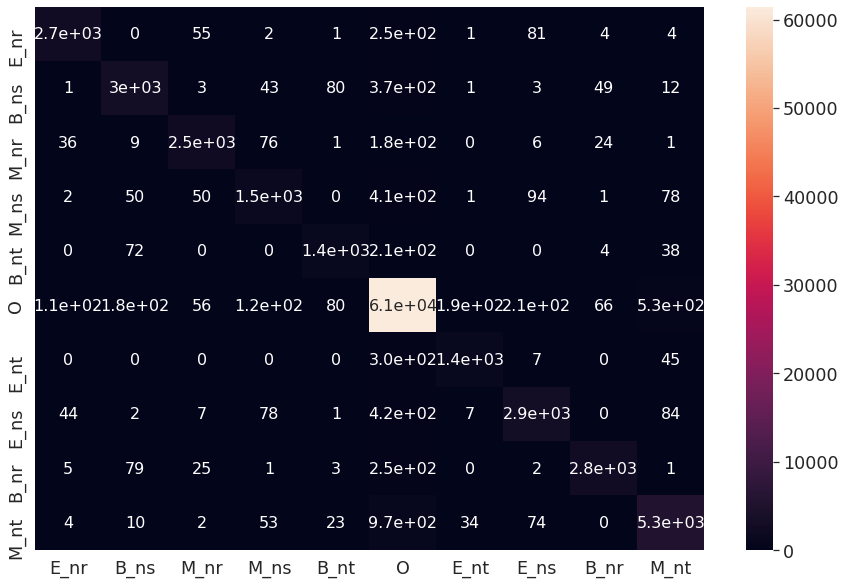

In [61]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, index=id2tag.values(), columns=id2tag.values())
plt.figure(figsize=(15, 10))
sn.set(font_scale=1.6)  # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size

plt.show()

In [66]:
texts = "张三被人称做武汉市的潘长江"
texts = [word2id[char] for char in texts]
[id2tag[idx] for idx in model.predict([texts],[len(texts)])[0]]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'M_nr']

In [63]:
texts

[243, 169, 388, 6, 720, 391, 505, 776, 40, 1, 1283, 56, 263]

In [64]:
for char in texts:
    print(id2word[char])

张
三
被
人
称
做
武
汉
市
的
潘
长
江


In [67]:
model.transition_params

<tf.Variable 'Variable:0' shape=(10, 10) dtype=float32, numpy=
array([[-1.4565768 , -0.2668708 , -1.4588898 , -0.96626824,  0.7774348 ,
         1.3503712 , -0.42583653, -0.670542  ,  1.013316  , -1.2852898 ],
       [-1.6923217 , -1.8564918 , -2.0272608 ,  2.5345836 , -0.53357553,
        -1.5543331 , -0.75915736,  2.535033  , -0.84643745, -1.6576437 ],
       [ 2.6982732 , -1.1180472 ,  1.580841  , -1.1378007 ,  0.02719036,
        -1.4680803 , -0.8082865 , -1.1196982 , -1.247668  , -1.1725149 ],
       [-1.3088363 , -1.6260566 , -0.8690887 ,  2.3284018 , -0.19171521,
        -1.4200029 , -1.7348543 ,  2.4578133 , -0.69194967, -1.426078  ],
       [-1.1099789 , -1.3653592 , -1.2233981 , -1.7706767 , -1.6521014 ,
        -1.3060299 , -0.5044783 , -1.5118856 ,  0.03823521,  2.347221  ],
       [-1.4294145 ,  1.3479629 , -1.0984501 , -0.8855818 ,  1.4003327 ,
         1.846974  , -2.1977484 , -1.0670334 ,  1.50594   , -1.6302812 ],
       [-0.42180887,  1.4681315 , -0.15112583, -0.67110

In [68]:
transitons = pd.DataFrame(model.transition_params.numpy(),
                          index=id2tag.values(),
                          columns=id2tag.values())
transitons

,E_nr,B_ns,M_nr,M_ns,B_nt,O,E_nt,E_ns,B_nr,M_nt
E_nr,-1.456577,-0.266871,-1.458890,-0.966268,0.777435,1.350371,-0.425837,-0.670542,1.013316,-1.285290
B_ns,-1.692322,-1.856492,-2.027261,2.534584,-0.533576,-1.554333,-0.759157,2.535033,-0.846437,-1.657644
M_nr,2.698273,-1.118047,1.580841,-1.137801,0.027190,-1.468080,-0.808286,-1.119698,-1.247668,-1.172515
M_ns,-1.308836,-1.626057,-0.869089,2.328402,-0.191715,-1.420003,-1.734854,2.457813,-0.691950,-1.426078
B_nt,-1.109979,-1.365359,-1.223398,-1.770677,-1.652101,-1.306030,-0.504478,-1.511886,0.038235,2.347221
O,-1.429415,1.347963,-1.098450,-0.885582,1.400333,1.846974,-2.197748,-1.067033,1.505940,-1.630281
E_nt,-0.421809,1.468132,-0.151126,-0.671110,0.287980,1.222099,-1.526036,0.243021,0.523459,-1.336419
E_ns,-0.988488,1.671640,-0.647701,-1.180912,0.535741,1.998259,-0.234210,-1.066995,0.958367,-2.033767
B_nr,1.954069,-0.704388,1.978173,-1.074977,-0.446990,-1.496067,0.051470,-1.768979,-2.036043,-0.852942
M_nt,-0.918321,-1.383824,-0.864366,-1.519459,-1.955153,-1.713201,2.427616,-1.619348,-0.513195,1.805165
